## Loading data ...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from skimage import color
from skimage import io
from sklearn.model_selection import train_test_split
import torch 
import torchvision

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0)

In [2]:
def load_data(path):
    """ Helper function for loading a MAT-File"""
    data = loadmat(path)
    return data['X'], data['y']

X_train, y_train = load_data('train_32x32.mat')
X_test, y_test = load_data('test_32x32.mat')

print("Training Set", X_train.shape, y_train.shape)
print("Test Set", X_test.shape, y_test.shape)

Training Set (32, 32, 3, 73257) (73257, 1)
Test Set (32, 32, 3, 26032) (26032, 1)


#### Transposing the the train and test data by converting it from (width, height, channels, size) -> (size, width, height, channels)

In [3]:
# Transpose the image arrays
X_train, y_train = X_train.transpose((3,0,1,2)), y_train[:,0]
X_test, y_test = X_test.transpose((3,0,1,2)), y_test[:,0]

print("Training Set", X_train.shape)
print("Test Set", X_test.shape)
print('')

# Calculate the total number of images
num_images = X_train.shape[0] + X_test.shape[0]

print("Total Number of Images", num_images)

Training Set (73257, 32, 32, 3)
Test Set (26032, 32, 32, 3)

Total Number of Images 99289


In [6]:
def plot_images(img, labels, nrows, ncols):
    """ Plot nrows x ncols images
    """
    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flat): 
        if img[i].shape == (32, 32, 3):
            ax.imshow(img[i])
        else:
            ax.imshow(img[i,:,:,0])
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(labels[i])

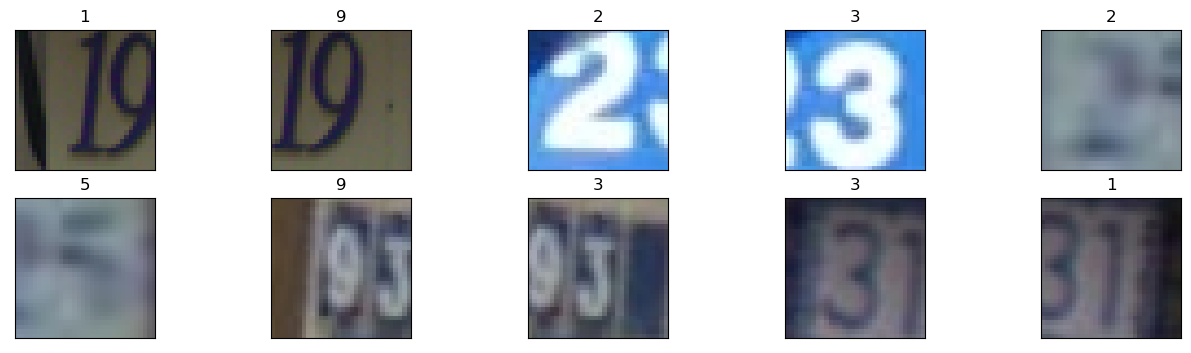

In [7]:
# Plot some training set images
plot_images(X_train, y_train, 2, 5)

## Preprocess data ...

In [4]:
# Data Normalization
# Conversion to float
X_train = X_train.astype('float32') 
X_test = X_test.astype('float32')
# Normalization
X_train = X_train/255.0
X_test = X_test/255.0

# Reshaping input data
X_train = X_train.reshape(len(X_train),-1)
X_test = X_test.reshape(len(X_test),-1)

# Checking the shape
print(X_train.shape)
print(X_test.shape)

(73257, 3072)
(26032, 3072)


### MiniBatchKMeans

In [5]:
from sklearn.cluster import MiniBatchKMeans
total_clusters = len(np.unique(y_test)) # 10
max_iter = 1000

# Initialize the K-Means model
kmeans = MiniBatchKMeans(n_clusters = total_clusters, max_iter = max_iter, random_state=0)
# Fitting the model to training set
kmeans.fit(X_train)

MiniBatchKMeans(max_iter=1000, n_clusters=10, random_state=0)

In [67]:
# kmeans.labels_ # len=73257

array([3, 3, 2, ..., 8, 8, 8], dtype=int32)

In [6]:
def retrieve_info(cluster_labels,y_train):
    reference_labels = {}
    for i in range(len(np.unique(kmeans.labels_))):
        index = np.where(cluster_labels == i,1,0)
        num = np.bincount(y_train[index==1]).argmax()
        reference_labels[i] = num
    return reference_labels

In [7]:
reference_labels = retrieve_info(kmeans.labels_,y_train)
number_labels = np.random.rand(len(kmeans.labels_))
for i in range(len(kmeans.labels_)):
    number_labels[i] = reference_labels[kmeans.labels_[i]]

# Comparing Predicted values and Actual values
# print(number_labels[:20].astype(‘int’))
# print(y_train[:20])

from sklearn.metrics import accuracy_score
print(accuracy_score(number_labels,y_train))

0.18921058738414076


## Further optimization ...

Increase the number of clusters.

A question to ponder is that why do we need more clusters when there are only 10 digits. This is because there can be multiple ways to write a particular number. The orientation and style of writing a number can be different and thus the algorithm views them as drastically different images. Hence we need more than 1 cluster to represent the images of a particular number.

Source: https://goodboychan.github.io/python/machine_learning/natural_language_processing/vision/2020/10/26/01-K-Means-Clustering-for-Imagery-Analysis.html 

In [7]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    # Loop through the clusters
    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]
        
    return inferred_labels  

def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [10]:
cluster_labels = infer_cluster_labels(kmeans, y_train)
X_clusters = kmeans.predict(X_train)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)
print(predicted_labels[:20])
print(y_train[:20])

[1 5 6 4 2 2 1 5 1 2 4 1 1 9 1 1 6 1 1 1]
[1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8]


In [13]:
from sklearn.metrics import homogeneity_score

def calc_metrics(estimator, data, labels):
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    # Inertia
    inertia = estimator.inertia_
    print("Inertia: {}".format(inertia))
    # Homogeneity Score
    homogeneity = homogeneity_score(labels, estimator.labels_)
    print("Homogeneity score: {}".format(homogeneity))
    return inertia, homogeneity

In [8]:
from sklearn.metrics import accuracy_score

In [13]:
from sklearn.metrics import accuracy_score

clusters = [10, 64, 144, 256, 500]
iner_list = []
homo_list = []
acc_list = []

for n_clusters in clusters:
    estimator = MiniBatchKMeans(n_clusters=n_clusters)
    estimator.fit(X_train)
    
    inertia, homo = calc_metrics(estimator, X_train, y_train)
    iner_list.append(inertia)
    homo_list.append(homo)
    
    # Determine predicted labels
    cluster_labels = infer_cluster_labels(estimator, y_train)
    prediction = infer_data_labels(estimator.labels_, cluster_labels)
    
    acc = accuracy_score(y_train, prediction)
    acc_list.append(acc)
    print('Accuracy: {}\n'.format(acc))

Number of Clusters: 10
Inertia: 3669998.0
Homogeneity score: 0.0011416381070217143
Accuracy: 0.18921058738414076

Number of Clusters: 64
Inertia: 2867376.5
Homogeneity score: 0.025162316689730176
Accuracy: 0.20454018046057032

Number of Clusters: 144
Inertia: 2655999.0
Homogeneity score: 0.04729319606477326
Accuracy: 0.22332336841530503

Number of Clusters: 256
Inertia: 2504683.0
Homogeneity score: 0.07319565342402078
Accuracy: 0.24811280833230953

Number of Clusters: 500
Inertia: 2355903.0
Homogeneity score: 0.11004621521492237
Accuracy: 0.2761237833927133



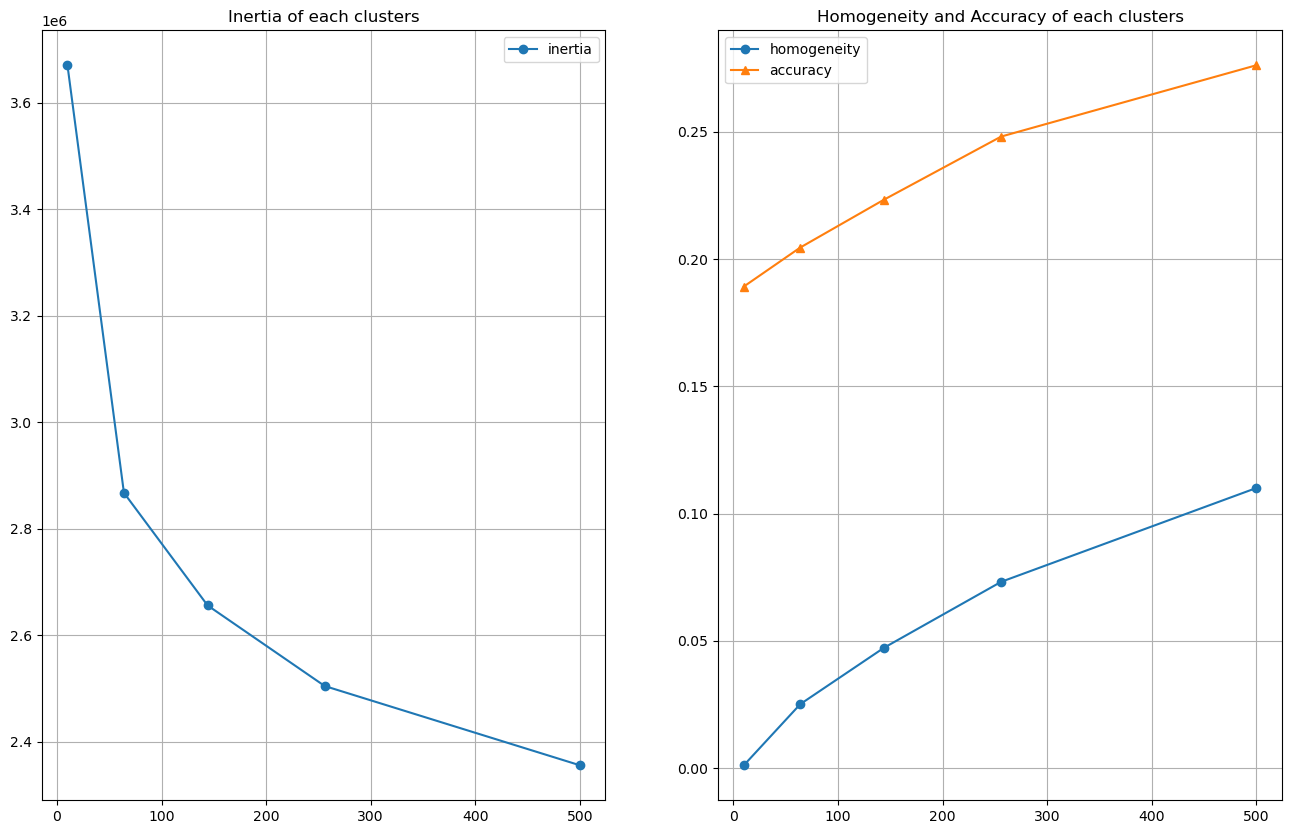

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(16, 10))
ax[0].plot(clusters, iner_list, label='inertia', marker='o')
ax[1].plot(clusters, homo_list, label='homogeneity', marker='o')
ax[1].plot(clusters, acc_list, label='accuracy', marker='^')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[0].grid('on')
ax[1].grid('on')
ax[0].set_title('Inertia of each clusters')
ax[1].set_title('Homogeneity and Accuracy of each clusters')
plt.show()

### Reduce Dimensionality

In [16]:
X_train.shape

(73257, 3072)

Let's compress our data using PCA to a degree that preserves 95% variance of the data and only looses 5%.

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95)
X_reduced = pca.fit_transform(X_train)
pca.n_components_

54

Only 54 out of 3072 features can preserve 95% of the data, which means SVHN is originally very sparse and most of the data is rather present at a much lower dimension.  

In [11]:
n_digits = 10
kmeans = MiniBatchKMeans(n_clusters=n_digits)
kmeans.fit(X_reduced)

reference_labels = retrieve_info(kmeans.labels_,y_train)
number_labels = np.random.rand(len(kmeans.labels_))

for i in range(len(kmeans.labels_)):
    number_labels[i] = reference_labels[kmeans.labels_[i]]

print(accuracy_score(number_labels,y_train))

0.27241082763421925


Number of Clusters: 10
Inertia: 3222992.5
Homogeneity score: 0.0014034967295088847
Accuracy: 0.18921058738414076

Number of Clusters: 64
Inertia: 2440572.25
Homogeneity score: 0.02727742859758875
Accuracy: 0.20328432777755026

Number of Clusters: 144
Inertia: 2211837.5
Homogeneity score: 0.050183320106854584
Accuracy: 0.22634014496908145

Number of Clusters: 256
Inertia: 2071226.5
Homogeneity score: 0.07251446761268406
Accuracy: 0.2444817560096646

Number of Clusters: 500
Inertia: 1924739.75
Homogeneity score: 0.1085355719896585
Accuracy: 0.2770247211870538



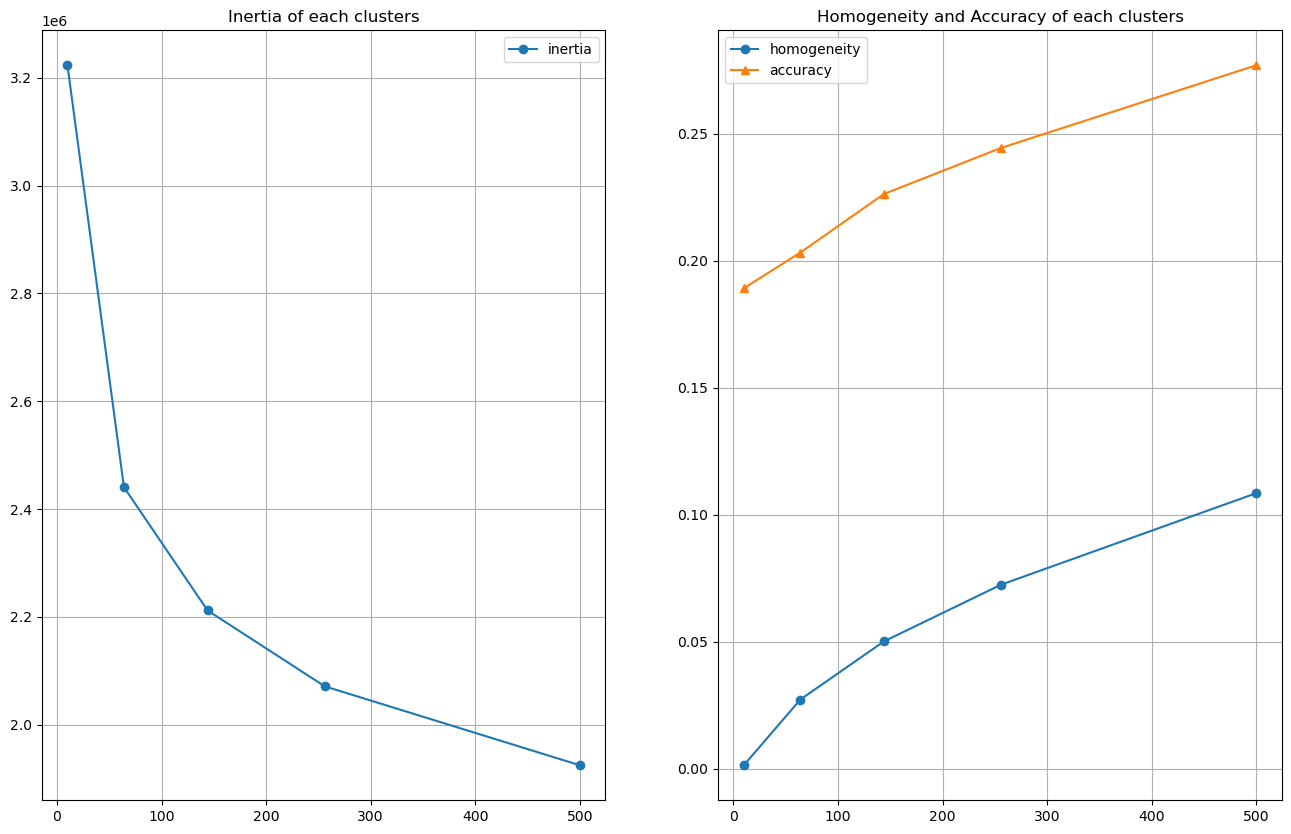

In [15]:
clusters = [10, 64, 144, 256, 500]
iner_list = []
homo_list = []
acc_list = []

for n_clusters in clusters:
    estimator = MiniBatchKMeans(n_clusters=n_clusters)
    estimator.fit(X_reduced)
    
    inertia, homo = calc_metrics(estimator, X_reduced, y_train)
    iner_list.append(inertia)
    homo_list.append(homo)
    
    # Determine predicted labels
    cluster_labels = infer_cluster_labels(estimator, y_train)
    prediction = infer_data_labels(estimator.labels_, cluster_labels)
    
    acc = accuracy_score(y_train, prediction)
    acc_list.append(acc)
    print('Accuracy: {}\n'.format(acc))

fig, ax = plt.subplots(1, 2, figsize=(16, 10))
ax[0].plot(clusters, iner_list, label='inertia', marker='o')
ax[1].plot(clusters, homo_list, label='homogeneity', marker='o')
ax[1].plot(clusters, acc_list, label='accuracy', marker='^')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[0].grid('on')
ax[1].grid('on')
ax[0].set_title('Inertia of each clusters')
ax[1].set_title('Homogeneity and Accuracy of each clusters')
plt.show()

## Viz

#### confusion matrix

In [26]:
total_clusters = 500 # 10
max_iter = 1000
kmeans = MiniBatchKMeans(n_clusters = total_clusters, max_iter = max_iter, random_state=0)
kmeans.fit(X_reduced)

cluster_labels = infer_cluster_labels(kmeans, y_train)
X_clusters = kmeans.predict(X_reduced)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)
print(predicted_labels[:20])
print(y_train[:20])

[ 1  1  2  2  1 10  1  2  5  1  1  7  1 10  2  1  6  1  1  2]
[1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8]


Text(0.5, 58.7222222222222, 'Prediction results')

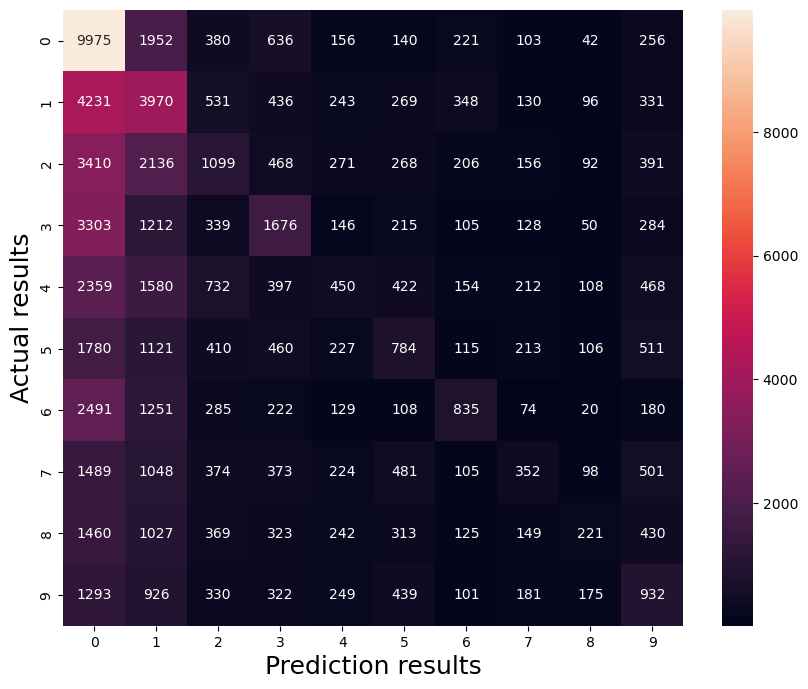

In [27]:
# from sklearn.metrics import confusion_matrix

# mat = confusion_matrix(y_train, prediction)
# sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
# plt.xlabel('true label')
# plt.ylabel('predicted label')

# confusion matrix
conf_mat = confusion_matrix(y_train, prediction)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual results',fontsize=18)
plt.xlabel('Prediction results',fontsize=18)